# NBA AI - Model Evaluation

### Imports and Global Settings

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pycaret import classification as pyc_cls
from pycaret import regression as pyc_reg
from tensorflow.keras.models import load_model
import autokeras as ak
import matplotlib.ticker as mtick

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
sns.set_style("whitegrid")
sns.set_context("notebook")
sns.set_palette(sns.color_palette())

2024-01-01 19:22:03.862703: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-01 19:22:03.911989: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-01 19:22:03.913159: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-01 19:22:04.866418: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using TensorFlow backend


### Loading Data

In [2]:
df_2021_2022 = pd.read_csv("../data/nba_ai/cleaned_data_2021-2022.csv")
df_2022_2023 = pd.read_csv("../data/nba_ai/cleaned_data_2022-2023.csv")

In [3]:
df_2022_2023.head()

,bigdataball_dataset,game_id,date,home_team,home_1q,home_2q,home_3q,home_4q,home_ot1,home_ot2,home_ot3,home_ot4,home_ot5,home_f,home_min,home_fg,home_fga,home_3p,home_3pa,home_ft,home_fta,home_or,home_dr,home_tot,home_a,home_pf,home_st,home_to,home_to_to,home_bl,home_pts,home_poss,home_pace,home_oeff,home_deff,home_team_rest_days,home_opening_spread,opening_total,home_closing_spread,closing_total,home_moneyline,season,season_type,home_starting_lineup,road_team,road_1q,road_2q,road_3q,road_4q,road_ot1,road_ot2,road_ot3,road_ot4,road_ot5,road_f,road_min,road_fg,road_fga,road_3p,road_3pa,road_ft,road_fta,road_or,road_dr,road_tot,road_a,road_pf,road_st,road_to,road_to_to,road_bl,road_pts,road_poss,road_pace,road_oeff,road_deff,road_team_rest_days,road_moneyline,road_starting_lineup,crew_chief,referee_umpire,day_of_season,home_team_game_num,road_team_game_num,home_eFG%,home_TOV%,home_ORB%,home_FT%,road_eFG%,road_TOV%,road_ORB%,road_FT%,winner,loser,home_wins,home_losses,home_win_pct,road_wins,road_losses,road_win_pct,home_wins_l2w,home_losses_l2w,home_win_pct_l2w,road_wins_l2w,road_losses_l2w,road_win_pct_l2w,home_avg_1q,road_avg_1q,home_avg_1q_l2w,road_avg_1q_l2w,home_avg_2q,road_avg_2q,home_avg_2q_l2w,road_avg_2q_l2w,home_avg_3q,road_avg_3q,home_avg_3q_l2w,road_avg_3q_l2w,home_avg_4q,road_avg_4q,home_avg_4q_l2w,road_avg_4q_l2w,home_avg_ot1,road_avg_ot1,home_avg_ot1_l2w,road_avg_ot1_l2w,home_avg_ot2,road_avg_ot2,home_avg_ot2_l2w,road_avg_ot2_l2w,home_avg_ot3,road_avg_ot3,home_avg_ot3_l2w,road_avg_ot3_l2w,home_avg_ot4,road_avg_ot4,home_avg_ot4_l2w,road_avg_ot4_l2w,home_avg_ot5,road_avg_ot5,home_avg_ot5_l2w,road_avg_ot5_l2w,home_avg_f,road_avg_f,home_avg_f_l2w,road_avg_f_l2w,home_avg_min,road_avg_min,home_avg_min_l2w,road_avg_min_l2w,home_avg_fg,road_avg_fg,home_avg_fg_l2w,road_avg_fg_l2w,home_avg_fga,road_avg_fga,home_avg_fga_l2w,road_avg_fga_l2w,home_avg_3p,road_avg_3p,home_avg_3p_l2w,road_avg_3p_l2w,home_avg_3pa,road_avg_3pa,home_avg_3pa_l2w,road_avg_3pa_l2w,home_avg_ft,road_avg_ft,home_avg_ft_l2w,road_avg_ft_l2w,home_avg_fta,road_avg_fta,home_avg_fta_l2w,road_avg_fta_l2w,home_avg_or,road_avg_or,home_avg_or_l2w,road_avg_or_l2w,home_avg_dr,road_avg_dr,home_avg_dr_l2w,road_avg_dr_l2w,home_avg_tot,road_avg_tot,home_avg_tot_l2w,road_avg_tot_l2w,home_avg_a,road_avg_a,home_avg_a_l2w,road_avg_a_l2w,home_avg_pf,road_avg_pf,home_avg_pf_l2w,road_avg_pf_l2w,home_avg_st,road_avg_st,home_avg_st_l2w,road_avg_st_l2w,home_avg_to,road_avg_to,home_avg_to_l2w,road_avg_to_l2w,home_avg_to_to,road_avg_to_to,home_avg_to_to_l2w,road_avg_to_to_l2w,home_avg_bl,road_avg_bl,home_avg_bl_l2w,road_avg_bl_l2w,home_avg_pts,road_avg_pts,home_avg_pts_l2w,road_avg_pts_l2w,home_avg_poss,road_avg_poss,home_avg_poss_l2w,road_avg_poss_l2w,home_avg_pace,road_avg_pace,home_avg_pace_l2w,road_avg_pace_l2w,home_avg_oeff,road_avg_oeff,home_avg_oeff_l2w,road_avg_oeff_l2w,home_avg_deff,road_avg_deff,home_avg_deff_l2w,road_avg_deff_l2w,home_avg_eFG%,road_avg_eFG%,home_avg_eFG%_l2w,road_avg_eFG%_l2w,home_avg_TOV%,road_avg_TOV%,home_avg_TOV%_l2w,road_avg_TOV%_l2w,home_avg_ORB%,road_avg_ORB%,home_avg_ORB%_l2w,road_avg_ORB%_l2w,home_avg_FT%,road_avg_FT%,home_avg_FT%_l2w,road_avg_FT%_l2w,home_avg_pts_allowed,road_avg_pts_allowed,home_avg_pts_allowed_l2w,road_avg_pts_allowed_l2w,REG_TARGET,CLS_TARGET,CLS_TARGET_closing_spread,REG_TARGET_OU,CLS_TARGET_OU_OPEN,CLS_TARGET_OU_CLOSE
0,NBA 2022-2023 Regular Season,22200001,2022-10-18,Boston,24,39,35,28,NaN,NaN,NaN,NaN,NaN,126,240.0,46,82,12,35,22,28,6,30,36,24,24,8,10,11,3,126,98.680535,98.680535,127.684756,118.564416,3+,-4.0,213.5,-3.0,216.5,-150,2023,-2023 Regular Season,"Jaylen Brown,Jayson Tatum,Al Horford,Derrick W...",Philadelphia,29,34,25,29,NaN,NaN,NaN,NaN,NaN,117,240.0,40,80,13,34,24,28,4,27,31,16,25,8,14,14,3,117,98.680535,98.680535,118.564416,127.684756,3+,+127,"Tobias Harris,P.J. Tucker,Joel Embiid,Tyrese M...",James Capers,"Brian Forte,Ray Acosta",1,1,1,0.634146,0.104444,0.139535,0.268293,0.581250,0.131678,0.093023,0.300000,Bo

<a name="data-setup"></a>

## Data Preparation

### Train Test Split

In [4]:
def prepare_datasets(train_df, cls_target, reg_target, test_df=None, test_size=0.3):
    """
    Prepares datasets for training and testing for both classification and regression targets,
    ensuring time-sensitive splitting based on a 'date' column.

    Parameters:
    train_df (DataFrame): The training dataframe.
    cls_target (str): The name of the classification target column.
    reg_target (str): The name of the regression target column.
    test_df (DataFrame, optional): An optional testing dataframe. If not provided, a portion of the training data is used.
    test_size (float, optional): The proportion of the dataset to include in the test split (if test_df is not provided).

    Returns:
    tuple: A tuple containing six dataframes:
           (X_train, X_test, y_train_cls, y_test_cls, y_train_reg, y_test_reg).
    """

    # Sort the dataframe based on the 'date' column
    train_df = train_df.sort_values(by="date")

    # If a test dataframe is not provided, split the training dataframe
    if test_df is None:
        X_train, X_test, y_train, y_test = train_test_split(
            train_df.drop([cls_target, reg_target], axis=1),
            train_df[[cls_target, reg_target]],
            test_size=test_size,
            shuffle=False,  # Important to maintain time order
        )
    else:
        # If a test dataframe is provided, ensure it is also sorted by date
        test_df = test_df.sort_values(by="date")

        # Use provided test dataframe and separate features and targets
        X_train = train_df.drop([cls_target, reg_target], axis=1)
        y_train = train_df[[cls_target, reg_target]]
        X_test = test_df.drop([cls_target, reg_target], axis=1)
        y_test = test_df[[cls_target, reg_target]]

    # Separate classification and regression targets
    y_train_cls = y_train[[cls_target]]
    y_train_reg = y_train[[reg_target]]
    y_test_cls = y_test[[cls_target]]
    y_test_reg = y_test[[reg_target]]

    return X_train, X_test, y_train_cls, y_test_cls, y_train_reg, y_test_reg

In [5]:
X_train, X_test, y_train_cls, y_test_cls, y_train_reg, y_test_reg = prepare_datasets(
    df_2021_2022, "CLS_TARGET", "REG_TARGET", test_df=df_2022_2023
)

### Features

In [6]:
betting_feature_set = [
    "home_opening_spread",
    "road_opening_spread",
    "opening_total",
    "home_closing_spread",
    "road_closing_spread",
    "closing_total",
    "home_moneyline",
    "road_moneyline",
]

base_feature_set = [
    "day_of_season",
    "home_win_pct",
    "road_win_pct",
    "home_win_pct_l2w",
    "road_win_pct_l2w",
    "home_avg_pts",
    "road_avg_pts",
    "home_avg_pts_l2w",
    "road_avg_pts_l2w",
    "home_avg_oeff",
    "road_avg_oeff",
    "home_avg_oeff_l2w",
    "road_avg_oeff_l2w",
    "home_avg_deff",
    "road_avg_deff",
    "home_avg_deff_l2w",
    "road_avg_deff_l2w",
    "home_avg_eFG%",
    "road_avg_eFG%",
    "home_avg_eFG%_l2w",
    "road_avg_eFG%_l2w",
    "home_avg_TOV%",
    "road_avg_TOV%",
    "home_avg_TOV%_l2w",
    "road_avg_TOV%_l2w",
    "home_avg_ORB%",
    "road_avg_ORB%",
    "home_avg_ORB%_l2w",
    "road_avg_ORB%_l2w",
    "home_avg_FT%",
    "road_avg_FT%",
    "home_avg_FT%_l2w",
    "road_avg_FT%_l2w",
    "home_avg_pts_allowed",
    "road_avg_pts_allowed",
    "home_avg_pts_allowed_l2w",
    "road_avg_pts_allowed_l2w",
]

features_to_prepare = [
    "home_team",
    "road_team",
    "home_team_rest_days",
    "road_team_rest_days",
    "home_team_starting_lineup",
    "road_team_starting_lineup",
]

In [7]:
X_train_all = X_train.copy()
X_test_all = X_test.copy()

X_train = X_train[base_feature_set]
X_test = X_test[base_feature_set]

## Model Predictions

In [8]:
automl_cls = pyc_cls.load_model(
    "../models/AutoML/Classification_Ridge_58_49_2023-12-30_18-37-09"
)
automl_reg = pyc_reg.load_model(
    "../models/AutoML/Regression_Ridge_11.16_12.54_2023-12-30_19-14-58"
)
autodl_cls = load_model(
    "../models/AutoDL/Classification_AutoKeras_47_49_2023-12-30_19-32-24",
    custom_objects=ak.CUSTOM_OBJECTS,
)
autodl_reg = load_model(
    "../models/AutoDL/Regression_AutoKeras_10.24_12.07_2023-12-30_19-40-49",
    custom_objects=ak.CUSTOM_OBJECTS,
)

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [9]:
automl_cls_predictions = pyc_cls.predict_model(automl_cls, data=X_test)[
    "prediction_label"
]
automl_reg_predictions = pyc_reg.predict_model(automl_reg, data=X_test)[
    "prediction_label"
]
autodl_cls_predictions = autodl_cls.predict(X_test).flatten().round()
autodl_reg_predictions = autodl_reg.predict(X_test).flatten()

42/42 [==============================] - 0s 2ms/step


## Performance Graphs

In [10]:
# Combine Predictions with Original Data for Graphing
graph_df = X_test_all[["date", "season", "season_type", "game_id"]].copy()
graph_df["actual_result_hv"] = y_test_reg
graph_df["vegas_line_hv"] = -X_test_all["home_opening_spread"]

# Adding predictions directly to the graph_df
graph_df["automl_reg_pred"] = automl_reg_predictions
graph_df["automl_cls_pred"] = automl_cls_predictions
graph_df["autodl_reg_pred"] = autodl_reg_predictions
graph_df["autodl_cls_pred"] = autodl_cls_predictions

### Regression - MAE - Bar Chart

In [11]:
def mae_comparison_bar_chart(actual, vegas_predictions, model_predictions):
    """
    Displays a vertical bar chart showing the Mean Absolute Error (MAE) of the Vegas
    predictions compared to each of the model predictions, with MAE values displayed inside the bars.

    Parameters:
    actual (list or array): Actual results of the games.
    vegas_predictions (list or array): Vegas predictions.
    model_predictions (dict): Dictionary of model predictions with model name as key.
    """
    # Calculate MAE for Vegas predictions
    vegas_mae = np.mean(np.abs(np.array(vegas_predictions) - np.array(actual)))

    # Calculate MAE for each model
    model_maes = {}
    for model_name, predictions in model_predictions.items():
        model_mae = np.mean(np.abs(np.array(predictions) - np.array(actual)))
        model_maes[model_name] = model_mae

    # Prepare data for bar chart
    model_names = list(model_maes.keys()) + ["Vegas"]
    maes = list(model_maes.values()) + [vegas_mae]

    # Create bar chart
    plt.figure(figsize=(10, 6))
    bars = sns.barplot(x=model_names, y=maes)

    # Add MAE values inside the bars
    for bar in bars.patches:
        bar_height = bar.get_height()
        # Adjust the position of the annotation inside the bar
        ypos = bar_height - (0.05 * bar_height) if bar_height > 0.1 else 0.01
        plt.annotate(
            format(bar_height, ".2f"),
            (bar.get_x() + bar.get_width() / 2, ypos),
            ha="center",
            va="center",
            color="white",
            size=14,
            xytext=(0, 0),
            textcoords="offset points",
        )

    plt.ylabel("Mean Absolute Error")
    plt.title("MAE Comparison of Vegas Predictions vs. Model Predictions")
    plt.show()

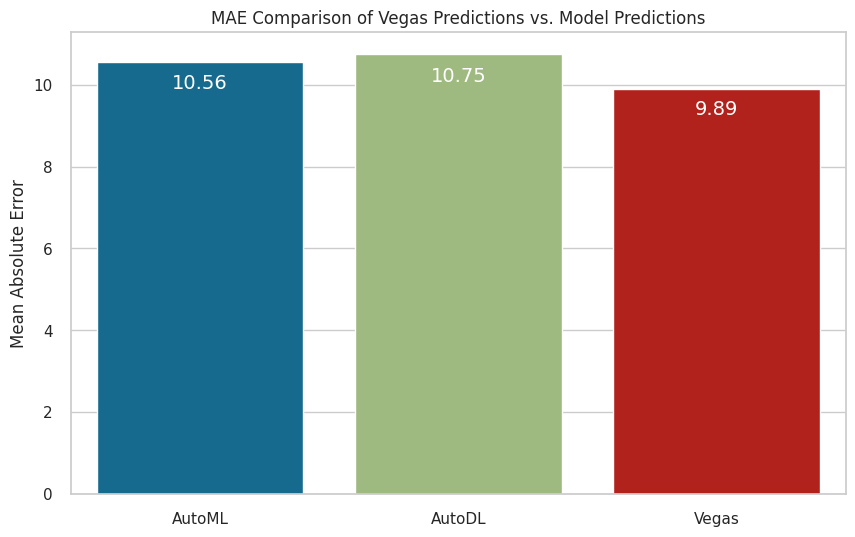

In [12]:
mae_comparison_bar_chart(
    graph_df["actual_result_hv"],
    graph_df["vegas_line_hv"],
    {"AutoML": graph_df["automl_reg_pred"], "AutoDL": graph_df["autodl_reg_pred"]},
)

### Regression - Time Series MAE - Line Chart

In [13]:
def mae_time_series_chart(
    actual, vegas_predictions, model_predictions, dates, seasons, aggregate_by="month"
):
    """
    Displays a line chart showing the Mean Absolute Error (MAE) of the Vegas predictions and each of the model predictions over time.
    Includes the overall MAE for each set in the legend.

    Parameters:
    actual (list or array): Actual results of the games.
    vegas_predictions (list or array): Vegas predictions.
    model_predictions (dict): Dictionary of model predictions with model name as key.
    dates (list or array): Dates of the games.
    seasons (list or array): Seasons of the games.
    aggregate_by (str): Aggregation method - 'month' or 'season'. Default is 'month'.
    """

    # Create a DataFrame for the data
    data = pd.DataFrame(
        {
            "Date": pd.to_datetime(dates),
            "Season": seasons,
            "Actual": actual,
            "Vegas": vegas_predictions,
        }
    )

    # Calculate MAE for Vegas predictions
    data["Vegas_MAE"] = np.abs(data["Vegas"] - data["Actual"])
    overall_vegas_mae = np.mean(data["Vegas_MAE"]).round(2)

    # Calculate MAE for each model and add to DataFrame
    for model_name, predictions in model_predictions.items():
        data[model_name + "_MAE"] = np.abs(np.array(predictions) - data["Actual"])
        model_predictions[model_name] = np.mean(data[model_name + "_MAE"]).round(2)

    # Aggregate by month or season
    if aggregate_by == "month":
        data["Month"] = data["Date"].dt.to_period("M")
        grouped = data.groupby("Month").mean()
    else:  # aggregate_by == 'season'
        grouped = data.groupby("Season").mean()

    # Plotting
    plt.figure(figsize=(15, 8))
    plt.plot(
        grouped.index.to_timestamp(),
        grouped["Vegas_MAE"],
        label=f"Vegas (Overall MAE: {overall_vegas_mae})",
        marker="o",
    )
    for model_name, overall_mae in model_predictions.items():
        plt.plot(
            grouped.index.to_timestamp(),
            grouped[model_name + "_MAE"],
            label=f"{model_name} (Overall MAE: {overall_mae})",
            marker="o",
        )

    plt.legend()
    plt.xlabel("Date" if aggregate_by == "month" else "Season")
    plt.ylabel("Mean Absolute Error")
    plt.title(f"MAE Over Time (Aggregated by {aggregate_by.capitalize()})")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

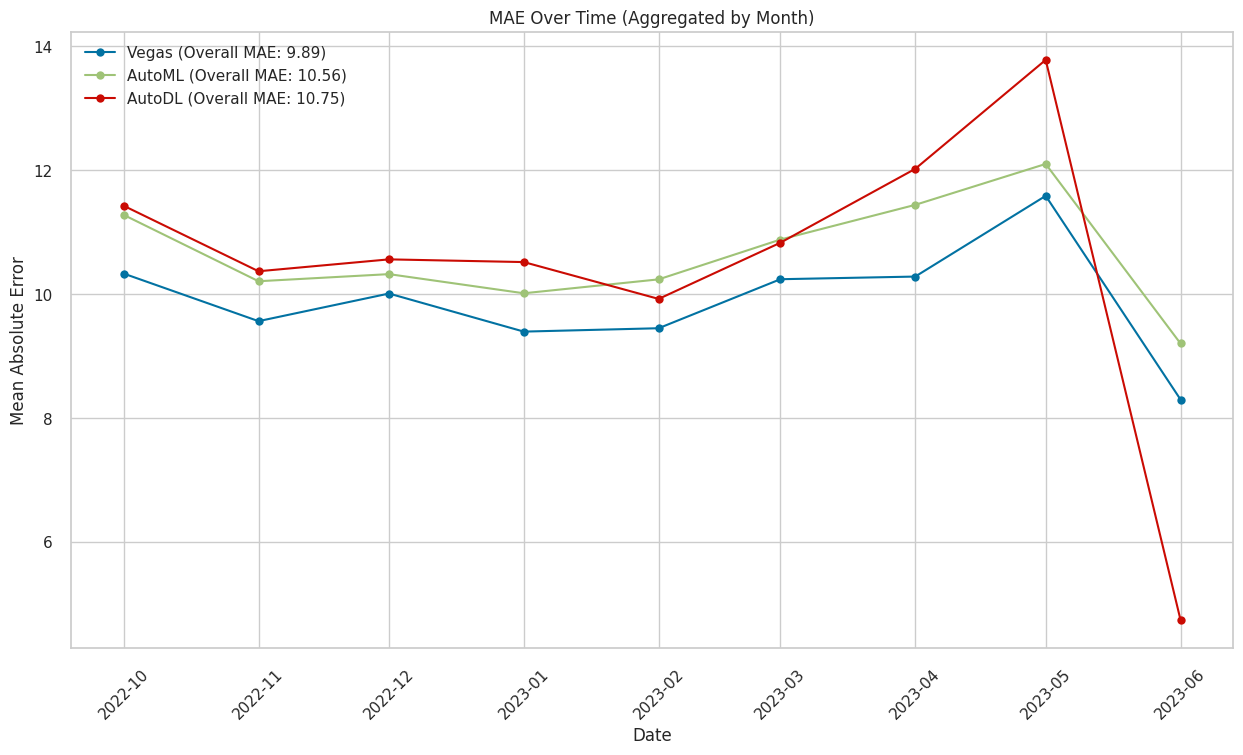

In [14]:
mae_time_series_chart(
    graph_df["actual_result_hv"],
    graph_df["vegas_line_hv"],
    {"AutoML": graph_df["automl_reg_pred"], "AutoDL": graph_df["autodl_reg_pred"]},
    graph_df["date"],
    graph_df["season"],
    aggregate_by="month",
)

### Classification - Accuracy - Bar Chart

In [15]:
def accuracy_comparison_bar_chart(
    actual, vegas_predictions, model_predictions, show_baselines=True
):
    """
    Displays a vertical bar chart showing the accuracy of each model's binary predictions,
    including optional baseline accuracies.

    Parameters:
    actual (list or array): Actual results of the games.
    vegas_predictions (list or array): Vegas predictions.
    model_predictions (dict): Dictionary of model binary predictions with model name as key.
    show_baselines (bool): Whether to show baseline accuracies. Default is True.
    """

    # Function to calculate accuracy
    def calculate_accuracy(actual, predictions, vegas):
        correct_predictions = (
            predictions == (np.array(actual) > np.array(vegas))
        ).astype(int)
        return np.mean(correct_predictions)

    # Calculate accuracy for each model
    model_accuracies = {
        model_name: calculate_accuracy(actual, np.array(predictions), vegas_predictions)
        * 100
        for model_name, predictions in model_predictions.items()
    }  # Convert to percentages

    # Baselines
    if show_baselines:
        always_over_accuracy = (
            np.mean(np.array(actual) > np.array(vegas_predictions)) * 100
        )  # Convert to percentage
        model_accuracies["Random Guess"] = 50.0
        model_accuracies["Profitable"] = 52.4
        model_accuracies["Always Over"] = always_over_accuracy

    # Prepare data for bar chart
    model_names = list(model_accuracies.keys())
    accuracies = list(model_accuracies.values())

    # Create bar chart
    plt.figure(figsize=(12, 6))
    bars = sns.barplot(x=model_names, y=accuracies)

    # Add accuracy values inside the bars
    for bar in bars.patches:
        bar_height = bar.get_height()
        # Adjust the position of the annotation inside the bar
        ypos = bar_height - (0.05 * bar_height) if bar_height > 0.1 else 0.01
        plt.annotate(
            format(bar_height, ".2f"),
            (bar.get_x() + bar.get_width() / 2, ypos),
            ha="center",
            va="center",
            color="white",
            size=14,
            xytext=(0, 0),
            textcoords="offset points",
        )

    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy Comparison of Model Predictions")
    plt.show()

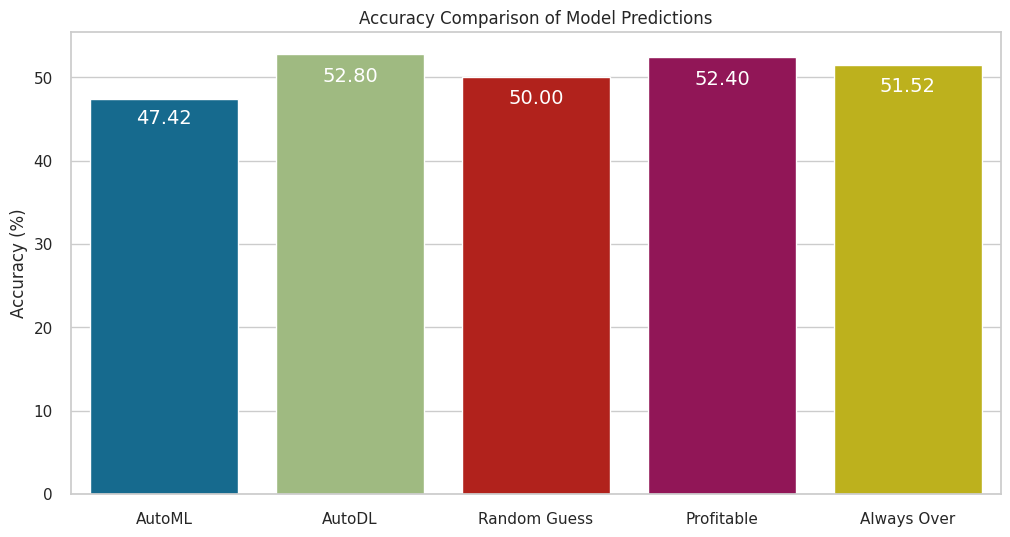

In [16]:
accuracy_comparison_bar_chart(
    graph_df["actual_result_hv"],
    graph_df["vegas_line_hv"],
    {"AutoML": graph_df["automl_cls_pred"], "AutoDL": graph_df["autodl_cls_pred"]},
)

### Classification - Time Series Accuracy - Line Chart

In [17]:
def accuracy_time_series_chart(
    actual,
    vegas_predictions,
    model_predictions,
    dates,
    seasons,
    aggregate_by="month",
    show_baselines=True,
):
    """
    Displays a line chart showing the accuracy of each model's binary predictions over time,
    including overall accuracy in the legend and optional baseline accuracies.
    The accuracy is displayed as a percentage. X-axis labels formatted as 'MM-YYYY'.

    Parameters:
    actual (list or array): Actual results of the games.
    vegas_predictions (list or array): Vegas predictions.
    model_predictions (dict): Dictionary of model binary predictions with model name as key.
    dates (list or array): Dates of the games.
    seasons (list or array): Seasons of the games.
    aggregate_by (str): Aggregation method - 'month' or 'season'. Default is 'month'.
    show_baselines (bool): Whether to show baseline accuracies. Default is True.
    """

    # Create a DataFrame for the data
    data = pd.DataFrame(
        {
            "Date": pd.to_datetime(dates),
            "Season": seasons,
            "ActualGreaterThanVegas": np.array(actual) > np.array(vegas_predictions),
        }
    )

    # Plotting
    plt.figure(figsize=(15, 8))

    # Calculate and plot accuracy for each model
    for model_name, predictions in model_predictions.items():
        # Calculate accuracy
        model_accuracy = (
            np.array(predictions) == data["ActualGreaterThanVegas"]
        ).astype(int)
        overall_accuracy = np.mean(model_accuracy).round(4)

        # Add to DataFrame for time series
        data[model_name + "_Accuracy"] = model_accuracy

        # Group data by month or season
        grouped = (
            data.groupby(data["Date"].dt.to_period("M")).mean()
            if aggregate_by.lower() == "month"
            else data.groupby("Season").mean()
        )

        # Plot with overall accuracy in label
        label = f"{model_name} (Overall Accuracy: {overall_accuracy*100:.2f}%)"
        ax = grouped.plot(
            y=model_name + "_Accuracy", label=label, marker="o", ax=plt.gca()
        )

    # Convert index to timestamp for plotting
    ax.set_xticks([i.to_timestamp() for i in grouped.index])
    ax.set_xticklabels(
        [i.to_timestamp().strftime("%m-%Y") for i in grouped.index], rotation=45
    )

    # Baselines
    if show_baselines:
        # Random Guess at 50%, Profitable at 52.4%, Always Over
        plt.axhline(y=0.5, color="gray", linestyle="--", label="Random Guess (50%)")
        plt.axhline(y=0.524, color="blue", linestyle="--", label="Profitable (52.4%)")
        always_over_accuracy = np.mean(data["ActualGreaterThanVegas"]).round(4)
        plt.axhline(
            y=always_over_accuracy,
            color="green",
            linestyle="--",
            label=f"Always Over ({always_over_accuracy*100:.2f}%)",
        )

    # Set y-axis to display percentage
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0, decimals=0))
    plt.legend()
    plt.xlabel("Date" if aggregate_by.lower() == "month" else "Season")
    plt.ylabel("Accuracy (%)")
    plt.title(
        f"Model Prediction Accuracy Over Time (Aggregated by {aggregate_by.capitalize()})"
    )
    plt.grid(True)
    plt.show()

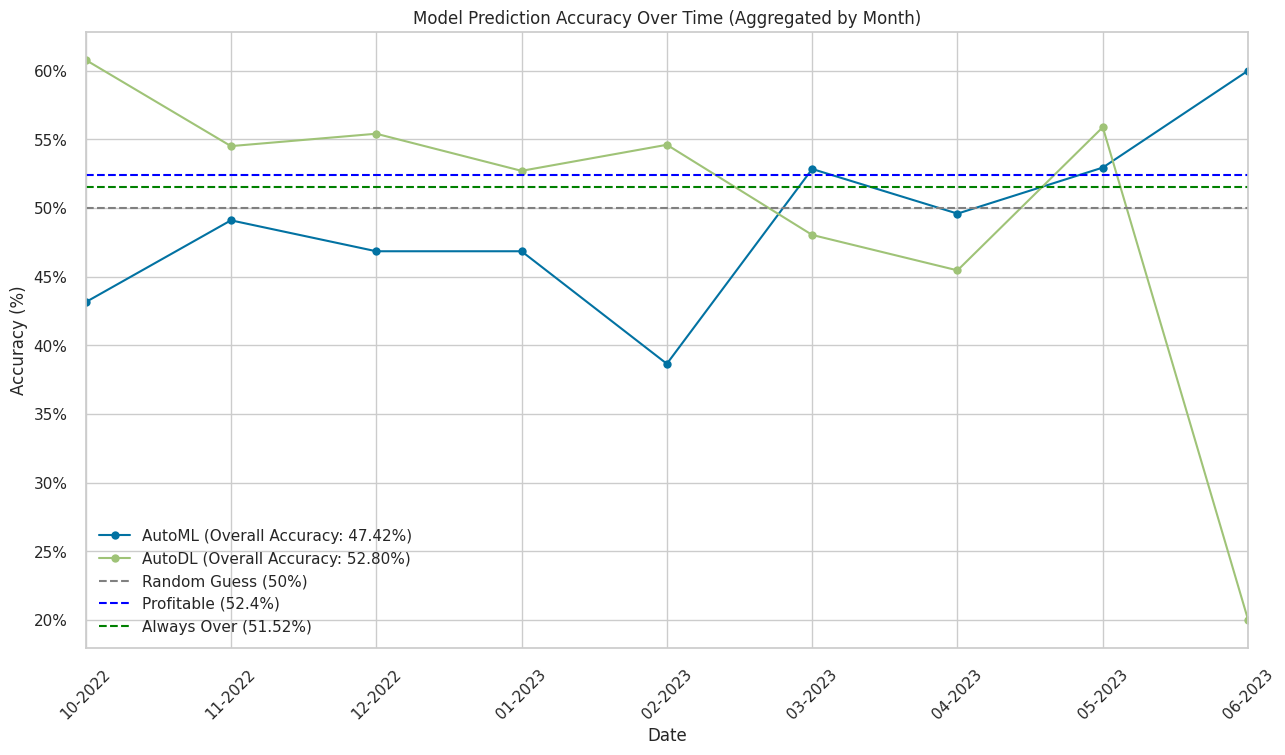

In [18]:
accuracy_time_series_chart(
    graph_df["actual_result_hv"],
    graph_df["vegas_line_hv"],
    {"AutoML": graph_df["automl_cls_pred"], "AutoDL": graph_df["autodl_cls_pred"]},
    graph_df["date"],
    graph_df["season"],
    aggregate_by="month",
    show_baselines=True,
)